**Basic fitting setup and run**

26/04/23

STATUS: copy-pasted bunch o'stuff from docs and dev notebooks, needs some work but mostly in place. Didn't add to build as yet.

See also:

- Sym fitting dev, http://jake:9966/lab/tree/QM3/doc-source/part2/sym-fitting_dev_130423.ipynb
- Sym fitting intro, http://jake:9966/lab/tree/QM3/doc-source/part2/sym-fitting-intro_220423.ipynb

For fitting stuff:

- Docs: https://pemtk.readthedocs.io/en/latest/fitting/PEMtk_fitting_basic_demo_030621-full_010922.html
- General: `code-share/jake-notebooks/pemtk-dev/multiFit_tests_and_parallel/`
- Initial QM3 build tests: http://jake:9966/lab/tree/code-share/jake-notebooks/pemtk-dev/multiFit_tests_and_parallel/PEMtk_fitting_multiproc_class_analysis_141121-SCRATCHpkgTest-hvplotTests-JAKE-QM3-docker_030423.ipynb
- MF recon manuscript plotting dev: http://jake:9966/lab/tree/code-share/stimpy-docker-local/MFPADs_recon_manuscript_dev_April_2022/MFrecon_manuscript_fig_generation_170422-Stimpy_MAIN-oldPkgs.ipynb

In this notebook cover pulling ePS data from standard sources, running fits and data IO.

TO DECIDE: full general intro here, or just run scripted version? In general there are a few things that might change, e.g. ADM times etc.

(sect:basic-fit-setup)=
# Basic fit setup and numerics

## Init and pulling data

Here the setup is mainly handled by some basic scripts, these follow the outline in the {{ PEMtk_docs }}, see in particular [the intro to fitting](https://pemtk.readthedocs.io/en/latest/fitting/PEMtk_fitting_basic_demo_030621-full_010922.html).

In [1]:
# Run default config - may need to set full path here
%run '../scripts/setup_notebook.py'

# Override plotters backend?
# plotBackend = 'pl'

*** Setting up notebook with standard Quantum Metrology Vol. 3 imports...
For more details see https://pemtk.readthedocs.io/en/latest/fitting/PEMtk_fitting_basic_demo_030621-full.html
To use local source code, pass the parent path to this script at run time, e.g. "setup_fit_demo ~/github"

*** Running: 2023-04-27 08:58:15
Working dir: /home/jovyan/QM3/doc-source/part2
Build env: notebook

* Loading packages...


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* Set Holoviews with bokeh.
Jupyter Book      : 0.15.1
External ToC      : 0.3.1
MyST-Parser       : 0.18.1
MyST-NB           : 0.17.2
Sphinx Book Theme : 1.0.1
Jupyter-Cache     : 0.6.1
NbClient          : 0.5.4


In [2]:

import wget
from pathlib import Path

dataName = 'n2fitting'

# Pull N2 data from ePSproc Github repo
# URLs for test ePSproc datasets - n2
# For more datasets use ePSdata, see https://epsproc.readthedocs.io/en/dev/demos/ePSdata_download_demo_300720.html
urls = {'n2PU':"https://github.com/phockett/ePSproc/blob/master/data/photoionization/n2_multiorb/n2_1pu_0.1-50.1eV_A2.inp.out",
        'n2SU':"https://github.com/phockett/ePSproc/blob/master/data/photoionization/n2_multiorb/n2_3sg_0.1-50.1eV_A2.inp.out",
        'n2ADMs':"https://github.com/phockett/ePSproc/blob/master/data/alignment/N2_ADM_VM_290816.mat",
        'demoScript':"https://github.com/phockett/PEMtk/blob/master/demos/fitting/setup_fit_demo.py"}



# Set data dir
dataPath = Path(Path.cwd(), dataName)

# Create and pull files if dir not present (NOTE doesn't check per file here)
if not dataPath.is_dir():
    dataPath.mkdir()

    # Pull files with wget
    for k,v in urls.items():
        wget.download(v+'?raw=true',out=dataPath.as_posix())  # For Github add '?raw=true' to URL


# List files
list(dataPath.glob('*.out')) + list(dataPath.glob('*.mat'))

[PosixPath('/home/jovyan/QM3/doc-source/part2/n2fitting/n2_1pu_0.1-50.1eV_A2.inp.out'),
 PosixPath('/home/jovyan/QM3/doc-source/part2/n2fitting/n2_3sg_0.1-50.1eV_A2.inp.out'),
 PosixPath('/home/jovyan/QM3/doc-source/part2/n2fitting/N2_ADM_VM_290816.mat')]

## Setup with options

Following the {{ PEMtk_docs }}, the fitting workspace can be configured by setting:

1. A fitting basis set, either from computational matrix elements, from symmetry constraints, or manually. (See {numref}`Sect. %s <sect:basis-sets:fitting-intro>` for more discussion.)
1. Data to fit. In the examples herein synthetic data will be created by adding noise to computational results.
1. {{ ADMs }} to use for the fit. Again these may be from computational results, or set manually. If not specified these will default to an isotropic distribution, which may be appropriate in some cases.

% More on ADMs elsewhere...?

In [3]:
# Init class object
data = pemtkFit(fileBase = dataPath, verbose = 1)

# Read data files
data.scanFiles()
# data.jobsSummary()


*** Job subset details
Key: subset
No 'job' info set for self.data[subset].

*** Job orb6 details
Key: orb6
Dir /home/jovyan/QM3/doc-source/part2/n2fitting, 1 file(s).
{   'batch': 'ePS n2, batch n2_1pu_0.1-50.1eV, orbital A2',
    'event': ' N2 A-state (1piu-1)',
    'orbE': -17.09691397835426,
    'orbLabel': '1piu-1'}

*** Job orb5 details
Key: orb5
Dir /home/jovyan/QM3/doc-source/part2/n2fitting, 1 file(s).
{   'batch': 'ePS n2, batch n2_3sg_0.1-50.1eV, orbital A2',
    'event': ' N2 X-state (3sg-1)',
    'orbE': -17.34181645456815,
    'orbLabel': '3sg-1'}


#### Alignment distribution moments (ADMs)

The class [wraps ep.setADMs()](https://epsproc.readthedocs.io/en/dev/modules/epsproc.sphCalc.html#epsproc.sphCalc.setADMs). This returns an isotropic distribution by default, or values can be set explicitly from a list. Values are set in `self.data['ADM']`.

Note: if this is not set, the default value will be used, which is likely not very useful for the fit!

In [4]:
# Default case
data.setADMs()
# data.ADM['ADMX']
data.data['ADM']['ADM']

<xarray.DataArray 'ADM' (ADM: 1, t: 1)>
array([[1]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0
  - Q        (ADM) int64 0
  - S        (ADM) int64 0
  * t        (t) int64 0
Attributes:
    dataType:   ADM
    long_name:  Axis distribution moments
    units:      arb

In [5]:
# Load time-dependent ADMs for N2 case
# Adapted from ePSproc_AFBLM_testing_010519_300719.m

from scipy.io import loadmat
ADMdataFile = os.path.join(dataPath, 'N2_ADM_VM_290816.mat')
ADMs = loadmat(ADMdataFile)

# Set tOffset for calcs, 3.76ps!!!
# This is because this is 2-pulse case, and will set t=0 to 2nd pulse (and matches defn. in N2 experimental paper)
tOffset = -3.76
ADMs['time'] = ADMs['time'] + tOffset

data.setADMs(ADMs = ADMs['ADM'], t=ADMs['time'].squeeze(), KQSLabels = ADMs['ADMlist'], addS = True)
data.data['ADM']['ADM']

<xarray.DataArray 'ADM' (ADM: 4, t: 3691)>
array([[ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j, ...,
         1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j],
       [-2.26243113e-17+0.00000000e+00j,  2.43430608e-08+1.04125246e-20j,
         9.80188266e-08+6.89166168e-20j, ...,
         1.05433798e-01-1.62495135e-18j,  1.05433798e-01-1.62495135e-18j,
         1.05433798e-01-1.62495135e-18j],
       [ 1.55724057e-16+0.00000000e+00j, -3.37021111e-10-6.81416260e-20j,
         1.95424253e-10-3.10513374e-19j, ...,
         8.39913132e-02-5.12795441e-17j,  8.39913132e-02-5.12795441e-17j,
         8.39913132e-02-5.12795441e-17j],
       [-7.68430227e-16+0.00000000e+00j, -1.40177466e-11+1.04987400e-19j,
         6.33419102e-10+1.74747003e-18j, ...,
         3.78131657e-02+4.01318983e-16j,  3.78131657e-02+4.01318983e-16j,
         3.78131657e-02+4.01318983e-16j]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0 2 4 6
  - Q        (ADM) int64 0 0 0 0
  - S        (ADM) int64 0 0 0 0
  * t        (t) float64 -3.76 -3.76 -3.76 -3.759 -3.759 ... 10.1 10.1 10.1 10.1
Attributes:
    dataType:   ADM
    long_name:  Axis distribution moments
    units:      arb

% PLOTTING - one liner with hvplot, or longer from http://jake:9966/lab/tree/code-share/stimpy-docker-local/MFPADs_recon_manuscript_dev_April_2022/MFrecon_manuscript_fig_generation_170422-Stimpy_MAIN-oldPkgs.ipynb

% ISN'T THIS NOW WRAPPED....????????

In [7]:
# Manual plot with hvplot
key = 'ADM'
dataType='ADM'
data.data[key][dataType].unstack().real.hvplot.line(x='t').overlay(['K','Q','S'])

:NdOverlay   [S,Q,K]
   :Curve   [t]   (ADM)

Dataset: ADM, ADM


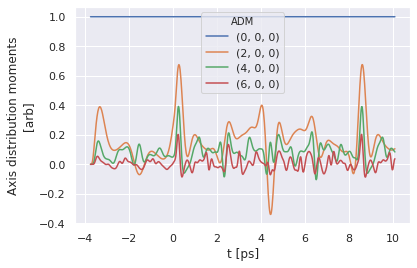

In [8]:
# Wrapper OK with Matplotlib, but needs work for hv case (see below)
%matplotlib inline
data.ADMplot(keys = 'ADM')

% **ADDITIONAL PLOTTING TESTS BELOW (HIDDEN IN OUTPUT)**

In [9]:
from epsproc.plot import hvPlotters  # Additional plotting code
from holoviews import opts, dim

# key = 'subset'
# dataType='ADM'

# daPlot = ep.matEleSelector(data.data[key][dataType], thres=1e-2, dims = 't', sq = True).squeeze()
# daPlot = ep.plotTypeSelector(daPlot, pType = 'r')

# from holoviews import opts, dim

# # Plot with widgets to handle dims - note this may require .unstack() for multindex objects
# # (subset.real.rename(str(key)))  # Convert to hv.Dataset, may need to rename too.
# # hvObj = hvPlotters.curvePlot(daPlot.rename(str(key)).unstack(), kdims='t', renderPlot=False)
# hvObj = hvPlotters.curvePlot(daPlot.rename(r'$\beta_{LM}$').unstack(), kdims='t', renderPlot=False).opts(line_dash='dashed') 
# # .opts(opts.Points(color='k', marker='+', size=10))  #.opts(line_dash='dashed',opts.Points(color='k', marker='+', size=10))  #, marker = 'x')
# # hvObj.overlay(['K','Q','S'])
# # hvObjMarkers = points.opts(color='k', marker='+', size=10)
# hvObjP = hvObj * daPlot.rename(r'$\beta_{LM}$').unstack().hvplot.scatter(x='t', marker = 'x', size = 100)  # Add points



key = 'ADM'
dataType='ADM'

daPlot = ep.matEleSelector(data.data[key][dataType], thres=1e-2, dims = 't', sq = True).squeeze()
daPlot = ep.plotTypeSelector(daPlot, pType = 'r')

# Plot with widgets to handle dims - note this may require .unstack() for multindex objects
# (subset.real.rename(str(key)))  # Convert to hv.Dataset, may need to rename too.
# hvObj = hvPlotters.curvePlot(daPlot.rename(str(key)).unstack(), kdims='t', renderPlot=False)
hvObj2 = hvPlotters.curvePlot(daPlot.rename(r'$\beta_{LM}$').unstack(), kdims='t', renderPlot=False)

# # (hvObj * hvObj2).overlay(['K','Q','S'])
# hvADMPlot = (hvObjP * hvObj2).overlay(['K','Q','S'])
# # hvObj
# hvADMPlot

hvObj2.overlay(['K','Q','S'])

:NdOverlay   [K,Q,S]
   :Curve   [t]   ($\beta_{LM}$)

In [10]:
data.data[key][dataType]

<xarray.DataArray 'ADM' (ADM: 4, t: 3691)>
array([[ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j, ...,
         1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j],
       [-2.26243113e-17+0.00000000e+00j,  2.43430608e-08+1.04125246e-20j,
         9.80188266e-08+6.89166168e-20j, ...,
         1.05433798e-01-1.62495135e-18j,  1.05433798e-01-1.62495135e-18j,
         1.05433798e-01-1.62495135e-18j],
       [ 1.55724057e-16+0.00000000e+00j, -3.37021111e-10-6.81416260e-20j,
         1.95424253e-10-3.10513374e-19j, ...,
         8.39913132e-02-5.12795441e-17j,  8.39913132e-02-5.12795441e-17j,
         8.39913132e-02-5.12795441e-17j],
       [-7.68430227e-16+0.00000000e+00j, -1.40177466e-11+1.04987400e-19j,
         6.33419102e-10+1.74747003e-18j, ...,
         3.78131657e-02+4.01318983e-16j,  3.78131657e-02+4.01318983e-16j,
         3.78131657e-02+4.01318983e-16j]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0 2 4 6
  - Q        (ADM) int64 0 0 0 0
  - S        (ADM) int64 0 0 0 0
  * t        (t) float64 -3.76 -3.76 -3.76 -3.759 -3.759 ... 10.1 10.1 10.1 10.1
Attributes:
    dataType:   ADM
    long_name:  Axis distribution moments
    units:      arb

Dataset: ADM, ADM


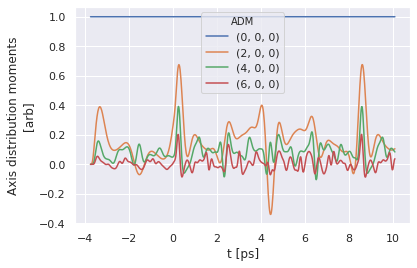

In [11]:
%matplotlib inline
data.ADMplot(keys = 'ADM')

### Polarisation geometry/ies

This wraps [ep.setPolGeoms](https://epsproc.readthedocs.io/en/dev/modules/epsproc.sphCalc.html#epsproc.sphCalc.setPolGeoms). This defaults to (x,y,z) polarization geometries. Values are set in `self.data['pol']`.

Note: if this is not set, the default value will be used, which is likely not very useful for the fit!


In [15]:
data.setPolGeoms()
data.data['pol']['pol']

<xarray.DataArray (Labels: 3)>
array([quaternion(1, -0, 0, 0),
       quaternion(0.707106781186548, -0, 0.707106781186547, 0),
       quaternion(0.5, -0.5, 0.5, 0.5)], dtype=quaternion)
Coordinates:
    Euler    (Labels) object (0.0, 0.0, 0.0) ... (1.5707963267948966, 1.57079...
  * Labels   (Labels) <U32 'z' 'x' 'y'
Attributes:
    dataType:  Euler

### Subselect data

Currently handled in the class by setting `self.selOpts`, this allows for simple reuse of settings as required. Subselected data is set to `self.data['subset'][dataType]`, and is the data the fitting routine will use.

In [16]:
# Settings for type subselection are in selOpts[dataType]

# E.g. Matrix element sub-selection
data.selOpts['matE'] = {'thres': 0.01, 'inds': {'Type':'L', 'Eke':1.1}}
data.setSubset(dataKey = 'orb5', dataType = 'matE')  # Subselect from 'orb5' dataset, matrix elements

# Show subselected data
# data.data['subset']['matE']

# Tabulate the matrix elements
# Not showing as nice table for singleton case - pd.series vs. dataframe?
# data.matEtoPD(keys = 'subset', xDim = 'Sym', drop=False)

# And for the polarisation geometries...
data.selOpts['pol'] = {'inds': {'Labels': 'z'}}
data.setSubset(dataKey = 'pol', dataType = 'pol')

# And for the ADMs...
data.selOpts['ADM'] = {}   #{'thres': 0.01, 'inds': {'Type':'L', 'Eke':1.1}}
data.setSubset(dataKey = 'ADM', dataType = 'ADM', sliceParams = {'t':[4, 5, 4]}) 

Subselected from dataset 'orb5', dataType 'matE': 36 from 11016 points (0.33%)
Subselected from dataset 'pol', dataType 'pol': 1 from 3 points (33.33%)
Subselected from dataset 'ADM', dataType 'ADM': 52 from 14764 points (0.35%)


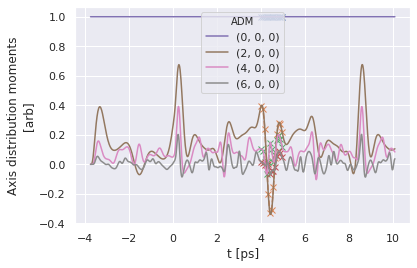

In [17]:
# Plot from Xarray vs. full dataset
# data.data['subset']['ADM'].where(ADMX['K']>0).real.squeeze().plot.line(x='t');
data.data['subset']['ADM'].real.squeeze().plot.line(x='t', marker = 'x', linestyle='dashed');
data.data['ADM']['ADM'].real.squeeze().plot.line(x='t');

## Compute AF-$\beta_{LM}$ and simulate data

With all the components set, some observables can be calculated. For testing, we'll also use this to simulate an experiemental trace...

Here we'll use `self.afblmMatEfit()`, which is also the main fitting routine, and essentially wraps `epsproc.afblmXprod()` to compute AF-$\beta_{LM}$s (for more details, see the [ePSproc method development docs](https://epsproc.readthedocs.io/en/dev/methods/geometric_method_dev_pt3_AFBLM_090620_010920_dev_bk100920.html)).

If called without reference data, the method returns computed AF-$\beta_{LM}$s based on the input subsets already created, and also a set of (product) basis functions generated - these can be examined to get a feel for the sensitivity of the geometric part of the problem, and will also be used in fitting to limit repetitive computation.

### Compute AF-$\beta_{LM}$s

In [18]:
# data.afblmMatEfit(data = None)  # OK
BetaNormX, basis = data.afblmMatEfit()  # OK, uses default polarizations & ADMs as set in data['subset']
# BetaNormX, basis = data.afblmMatEfit(ADM = data.data['subset']['ADM'])  # OK, but currently using default polarizations
# BetaNormX, basis = data.afblmMatEfit(ADM = data.data['subset']['ADM'], pol = data.data['pol']['pol'].sel(Labels=['x']))
# BetaNormX, basis = data.afblmMatEfit(ADM = data.data['subset']['ADM'], pol = data.data['pol']['pol'].sel(Labels=['x','y']))  # This fails for a single label...?
# BetaNormX, basis = data.afblmMatEfit(RX=data.data['pol']['pol'])  # This currently fails, need to check for consistency in ep.sphCalc.WDcalc()
                                                                    # - looks like set values and inputs are not consistent in this case? Not passing angs correctly, or overriding?
                                                                    # - See also recently-added sfError flag, which may cause additional problems.


### AF-$\beta_{LM}$s

The returned objects contain the $\beta_{LM}$ parameters as an Xarray...

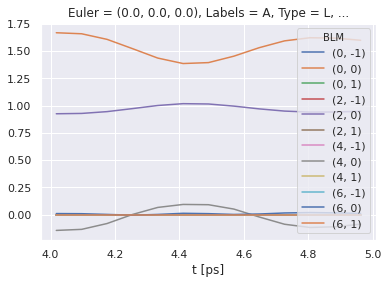

In [19]:
# Line-plot with Xarray/Matplotlib
# Note there is no filtering here, so this includes some invalid and null terms
BetaNormX.sel(Labels='A').real.squeeze().plot.line(x='t');

... and the basis sets as a dictionary.

In [20]:
basis.keys()

dict_keys(['BLMtableResort', 'polProd', 'phaseConvention', 'BLMRenorm'])

## Fitting the data

In order to fit data, and extract matrix elements from an experimental case, we'll use the [lmfit library](https://lmfit.github.io/lmfit-py/intro.html). This wraps core Scipy fitting routines with additional objects and methods, and is further wrapped for this specific class of problems in `pemtkFit` class we're using here.

### Set the data to fit

Here we'll use the values calculated above as our test data. This currently needs to be set as `self.data['subset']['AFBLM']` for fitting.

In [21]:
# data.data['subset']['AFBLM'] = BetaNormX  # Set manually

data.setData('sim', BetaNormX)  # Set simulated data to master structure as "sim"
data.setSubset('sim','AFBLM')   # Set to 'subset' to use for fitting.


Subselected from dataset 'sim', dataType 'AFBLM': 156 from 156 points (100.00%)


In [22]:
# Set basis functions
data.basis = basis

### Adding noise

Dataset: subset, AFBLM


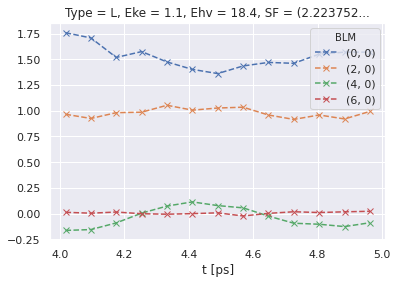

In [23]:
# Add noise with np.random.normal
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
# data.data['subset']['AFBLM']

import numpy as np
mu, sigma = 0, 0.05  # Up to approx 10% noise (+/- 0.05)
# creating a noise with the same dimension as the dataset (2,2) 
noise = np.random.normal(mu, sigma, [data.data['subset']['AFBLM'].t.size, data.data['subset']['AFBLM'].l.size])
# data.BLMfitPlot()

# Set noise in Xarray & scale by l
import xarray as xr
noiseXR = xr.ones_like(data.data['subset']['AFBLM']) * noise
# data.data['subset']['AFBLM']['noise'] = ((data.data['subset']['AFBLM'].t, data.data['subset']['AFBLM'].l), noise)
# xr.where(noiseXR.l>0, noiseXR/noiseXR.l, noiseXR)
noiseXR = noiseXR.where(noiseXR.l<1, noiseXR/(noiseXR.l))  # Scale by L

data.data['subset']['AFBLM'] = data.data['subset']['AFBLM'] + noiseXR
data.data['subset']['AFBLM'] = data.data['subset']['AFBLM'].where(data.data['subset']['AFBLM'].m == 0, 0)

data.BLMfitPlot()

### Setting up the fit parameters

In this case, we can work from the existing matrix elements to speed up parameter creation, although in practice this may need to be approached ab initio - nonetheless, the method will be the same, and the ab initio case detailed later.

In [24]:
# Input set, as defined earlier
# data.data['subset']['matE'].pd

In [25]:
# Set matrix elements from ab initio results
data.setMatEFit(data.data['subset']['matE'])

Set 6 complex matrix elements to 12 fitting params, see self.params for details.
Auto-setting parameters.


name,value,initial value,min,max,vary,expression
m_PU_SG_PU_1_n1_1_1,1.78461575,1.7846157536101068,1.0000e-04,5.00000000,True,
m_PU_SG_PU_1_1_n1_1,1.78461575,1.7846157536101068,1.0000e-04,5.00000000,False,m_PU_SG_PU_1_n1_1_1
m_PU_SG_PU_3_n1_1_1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,True,
m_PU_SG_PU_3_1_n1_1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,False,m_PU_SG_PU_3_n1_1_1
m_SU_SG_SU_1_0_0_1,2.68606212,2.686062120382649,1.0000e-04,5.00000000,True,
m_SU_SG_SU_3_0_0_1,1.10915311,1.109153108617096,1.0000e-04,5.00000000,True,
p_PU_SG_PU_1_n1_1_1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,False,
p_PU_SG_PU_1_1_n1_1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,False,p_PU_SG_PU_1_n1_1_1
p_PU_SG_PU_3_n1_1_1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,True,
p_PU_SG_PU_3_1_n1_1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,False,p_PU_SG_PU_3_n1_1_1


This sets `self.params` from the matrix elements, which are a set of (real) parameters for lmfit, as [a Parameters object](https://lmfit.github.io/lmfit-py/parameters.html). 

Note that: 

- The input matrix elements are converted to magnitude-phase form, hence there are twice the number as the input array, and labelled `m` or `p` accordingly, along with a name based on the full set of QNs/indexes set.
- One phase is set to `vary=False`, which defines a reference phase. This defaults to the first phase item.
- Min and max values are defined, by default the ranges are 1e-4<mag<5, -pi<phase<pi.
- Relationships between the parameters are set by default, but can be set manually, [see section below](#Setting-parameter-relations), or pass `paramsCons=None` to skip.

### Running fits

#### Single fit

With the parameters and data set, just call `self.fit()`!

Statistics and outputs are handled by lmfit, which includes uncertainty estimates and correlations in the fitted parameters.

In [27]:
# data.randomizeParams()  # Randomize input parameters if desired
                          # For method testing using known initial params is also useful
data.fit()

In [28]:
# Check fit outputs - self.result shows results from the last fit
data.result

Dataset: subset, AFBLM
Dataset: 0, AFBLM


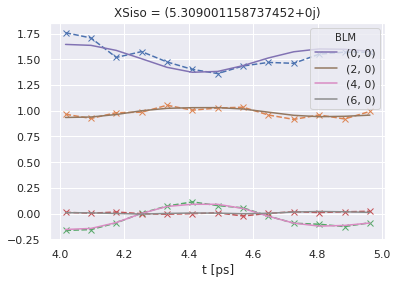

In [31]:
# Plot results with data
# data.BLMfitPlot(backend='hv')
data.BLMfitPlot()

#### Extended execution methods, including parallel and batched execution

See https://pemtk.readthedocs.io/en/latest/fitting/PEMtk_fitting_demo_multi-fit_tests_130621-para_010922.html

**(1) serial execution**

Either:

- Manually with a loop.
- With `self.multiFit()` method, although this is optimised for parallel execution (see below).

In [32]:
import time

start = time.time()

# Maual execution
for n in range(0,10):
    data.randomizeParams()
    data.fit()
    
end = time.time()
print((end - start)/60)
    
# Or run with self.multiFit(parallel = False)
# data.multiFit(nRange = [0,100], parallel = False)

1.5782841245333354


In [33]:
# We now have 10 fit results
data.data.keys()

dict_keys(['subset', 'orb6', 'orb5', 'ADM', 'pol', 'sim', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

**(b) parallel execution**

Updated version including parallel fitting routine with `self.multiFit()` method. 

This currently uses the [XYZpy library](https://xyzpy.readthedocs.io/en/latest/) for quick parallelization, although there is some additional setup overhead in the currently implementation due to class init per fit batch. The default aims to set ~90% CPU usage, based on core-count.

In [34]:
# Multifit wrapper with range of fits specified
# Set 'num_workers' to override the default.
data.multiFit(nRange = [0,10], num_workers=20)

Number of processors:  64 
Running pool on:  20


  0%|          | 0/10 [00:00<?, ?it/s]OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels i

**(c) Dump data**

Various options are available. The most complete is to use Pickle (default case), although this is not suggested for archival use. For details see https://epsproc.readthedocs.io/en/dev/dataStructures/ePSproc_dataStructures_demo_070622.html

In [35]:
outStem = 'dataDump_N2'  # Set for file save later

# data.writeFitData(fName='N2_datadump')  # Use 'fName' to supply a filename
data.writeFitData(dataPath = dataPath, outStem=outStem)  # Use 'outStem' to define a filename which will be appended with a timestamp
                                                        # Set dataPath if desired, otherwise will use working dir


Dumped self.data to /home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-03-46.pickle with pickle.
Dumped data to /home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-03-46.pickle with pickle.


PosixPath('/home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-03-46.pickle')

#### Batch fit with sampling options

From dev work

In [36]:
# Batch fit with data weighting example
batchSize = 50

# from datetime import datetime as dt
# import pickle

# outStem = 'dataDump_weights_bootstrap_tests'

data.data['weights'] = {}  # Use to log ref weights, will be overwritten otherwise

for n in np.arange(0,100,batchSize):
    print(f'Running batch [{n},{n+batchSize-1}]')

    # Reset weights
    data.setWeights(wConfig = 'poission', keyExpt='sim')   # v2 with setWeights, set to 'subset' to use for fitting.
    data.setSubset('sim','weights')   # Set to 'subset' to use for fitting.

    data.data['weights'][n] = data.data['sim']['weights'].copy()
    
    # Run fit batch
    data.multiFit(nRange = [n,n+batchSize-1], num_workers=20)
    
    # Checkpoint
    data.writeFitData(outStem=outStem)
    
    # timeString = dt.now()
    # fOut = f'{outStem}_n{n}_{timeString.strftime("%d%m%y_%H-%M-%S")}.pickle'
    # with open(fOut, 'wb') as handle:
    #     pickle.dump(data.data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Running batch [0,49]
Subselected from dataset 'sim', dataType 'weights': 156 from 156 points (100.00%)
Number of processors:  64 
Running pool on:  20


  0%|          | 0/49 [00:00<?, ?it/s]OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels i

* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not availabl

  8%|8         | 4/49 [00:50<09:31, 12.71s/it]

* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not availabl

100%|##########| 49/49 [01:20<00:00,  1.65s/it]


Dumped self.data to /home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-05-07.pickle with pickle.
Dumped data to /home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-05-07.pickle with pickle.
Running batch [50,99]
Subselected from dataset 'sim', dataType 'weights': 156 from 156 points (100.00%)
Number of processors:  64 
Running pool on:  20


  0%|          | 0/49 [00:00<?, ?it/s]OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  2%|2         | 1/49 [00:04<03:15,  4.07s/it]OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine depr

* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not availabl

 33%|###2      | 16/49 [01:13<02:32,  4.62s/it]

* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 


100%|##########| 49/49 [01:53<00:00,  2.32s/it]

Dumped self.data to /home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-07-01.pickle with pickle.
Dumped data to /home/jovyan/QM3/doc-source/part2/dataDump_N2_270423_09-07-01.pickle with pickle.


* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.
* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 


## Quick setup with script

The steps demonstrated above are also wrapped in a helper script, although some steps may need to be re-run to change selection properties or ranges.

In [ ]:
# Run general config script with dataPath set above
%run {dataPath/"setup_fit_demo.py"} -d {dataPath}

# SCRATCH

Plot testing below mainly.

Outputs hidden, but note these STILL EXECUTE at build.

In [12]:
from epsproc.sphFuncs.sphConv import checkSphDims
checkSphDims(data.data[key][dataType])

<xarray.DataArray 'ADM' (ADM: 4, t: 3691)>
array([[ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j, ...,
         1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j],
       [-2.26243113e-17+0.00000000e+00j,  2.43430608e-08+1.04125246e-20j,
         9.80188266e-08+6.89166168e-20j, ...,
         1.05433798e-01-1.62495135e-18j,  1.05433798e-01-1.62495135e-18j,
         1.05433798e-01-1.62495135e-18j],
       [ 1.55724057e-16+0.00000000e+00j, -3.37021111e-10-6.81416260e-20j,
         1.95424253e-10-3.10513374e-19j, ...,
         8.39913132e-02-5.12795441e-17j,  8.39913132e-02-5.12795441e-17j,
         8.39913132e-02-5.12795441e-17j],
       [-7.68430227e-16+0.00000000e+00j, -1.40177466e-11+1.04987400e-19j,
         6.33419102e-10+1.74747003e-18j, ...,
         3.78131657e-02+4.01318983e-16j,  3.78131657e-02+4.01318983e-16j,
         3.78131657e-02+4.01318983e-16j]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0 2 4 6
  - Q        (ADM) int64 0 0 0 0
  - S        (ADM) int64 0 0 0 0
  * t        (t) float64 -3.76 -3.76 -3.76 -3.759 -3.759 ... 10.1 10.1 10.1 10.1
Attributes:
    dataType:   ADM
    long_name:  Axis distribution moments
    units:      arb
    harmonics:  {'keyDims': {'LM': ['l', 'm']}, 'LMStackFlag': False, 'stackD...

In [13]:
data.data[key][dataType].attrs['harmonics'] = {'stackDim':'ADM'}

# Standard case:
# {'dtype': 'Complex harmonics', 'kind': 'complex', 'normType': 'ortho', 'csPhase': True, 'keyDims': {'LM': ['l', 'm']}, 'LMStackFlag': True, 'stackDim': 'LM', 'dimList': ['l', 'm'], 'lDim': 'l', 'mDim': 'm'}

# The ADMplot routine will show a basic line plot, note it needs keys = 'ADM' in the current implementation (otherwise will loop over all keys)
data.ADMplot(keys = 'ADM', backend = 'hv')  #, returnPlot=True, renderPlot=False)

# THIS CURRENTLY FAILS
# hvDS = hvPlotters.hv.Dataset(xrDS.unstack(xrDS.attrs['harmonics']['stackDim']))
# NEED TO SET stackDims correctly for ADMs!

ValueError: Dataset does not contain the dimensions: ['LM']

In [14]:
# SAME ISSUES AS ABOVE WITH SPH DEFINITIONS
# Expand ADMs to P(theta)
data.data['ADM']['ADM'].attrs['jobLabel'] = 'ADMs'

# Old version
# ADMdistFull = data.padPlot(keys = 'ADM', dataType='ADM', Etype = 't', pType='r', pStyle='grid', reducePhi='sum', returnFlag = True, sumDims = {})

# Updated 23/04/22
data.padPlot(keys = 'ADM', dataType='ADM', Etype = 't', pType='r', pStyle='grid', reducePhi='sum', returnFlag = True, sumDims = {})
ADMdistFull = data.data['ADM']['plots']['ADM']['pData']

KeyError: 'kind'